In [1]:
import astropy.coordinates as coord
import astropy.units as u
import astropy.table as at
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import daft
from pyia import GaiaData
import arviz as az
import pymc as pm
import numpy as np
from astropy.io import ascii
import theano.tensor as tt
import pdb

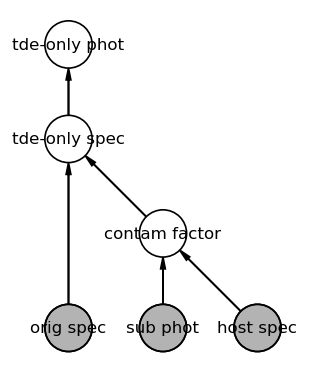

In [2]:
pgm = daft.PGM(dpi=120)

pgm.add_node("original spec", "orig spec", 0, 0, observed=True)
pgm.add_node("subtracted phot", "sub phot", 1, 0, observed=True)
pgm.add_node("host spec", "host spec", 2, 0, observed=True)
pgm.add_node("contam factor", "contam factor", 1, 1)
pgm.add_node("tde-only spec", "tde-only spec", 0, 2)
pgm.add_node("tde-only phot", "tde-only phot", 0, 3)

pgm.add_edge("host spec", "contam factor")
pgm.add_edge("subtracted phot", "contam factor")
pgm.add_edge("original spec", "tde-only spec")
pgm.add_edge("contam factor", "tde-only spec")
pgm.add_edge("tde-only spec", "tde-only phot")

pgm.render();

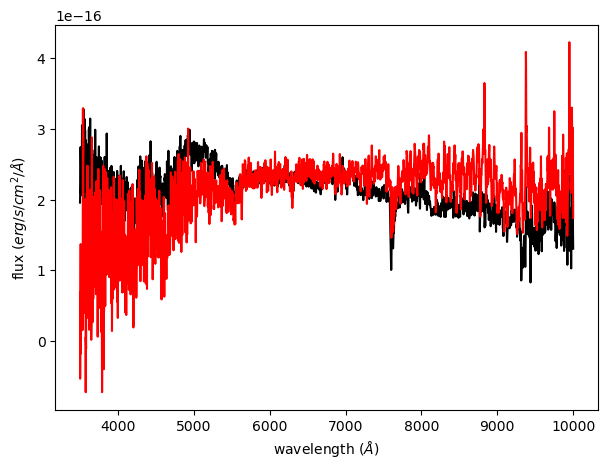

In [3]:
spectra = ascii.read('at2020mot_20200813_redblu_130115.430.ascii')
wavelength, flux = np.array(spectra['wavelength']), np.array(spectra['flux'])

hostspec = ascii.read('at2020mot_20220813_redblu_140224.122.ascii')
hostwave, hostflux = np.array(hostspec['wavelength']), np.array(hostspec['flux'])
hostflux = np.interp(wavelength, hostwave, hostflux)

plt.figure(figsize=(7, 5))
plt.plot(wavelength, flux, 'k')
plt.plot(wavelength, hostflux, color='red')
plt.title("")
plt.xlabel(r"wavelength ($\AA$)")
plt.ylabel(r"flux ($erg/s/cm^2/\AA$)")
plt.show()




In [10]:
import os
from astropy.io import fits
from scipy.optimize import root, minimize, least_squares
from astropy.io import ascii
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import argparse
import json
import pdb
import itertools
from astropy.time import Time
import scipy.optimize as op
import emcee
import corner
from scipy.interpolate import interp1d, splrep, splev

filter_filenames = {'u': 'sdss_u_005_syn.fits', 'g': 'sdss_g_005_syn.fits', 'r': 'sdss_r_005_syn.fits',
                    'i': 'sdss_i_005_syn.fits', #'z': 'sdss_z_005_syn.fits',
                    'y': 'PAN-STARRS_PS1.y.dat', 'z': 'PAN-STARRS_PS1.z.dat',
                    'PS1_i': 'PAN-STARRS_PS1.i.dat', 'PS1_g': 'PAN-STARRS_PS1.g.dat', 'PS1_r': 'PAN-STARRS_PS1.r.dat',
                    #'U': 'johnson_u_004_syn.fits',
                    'B': 'johnson_b_004_syn.fits', 'V': 'johnson_v_004_syn.fits',
                    'R': 'cousins_r_004_syn.fits', 'I': 'cousins_i_004_syn.fits',
                    'U': 'Swift-UVOT.U.fits', 'Swift/B': 'Swift-UVOT.B.fits',
                    'Swift/V': 'Swift-UVOT.V.fits', 'UVW1': 'Swift-UVOT.UVW1.fits',
                    'UVW2': 'Swift-UVOT.UVW2.fits', 'UVM2': 'Swift-UVOT.UVM2.fits',
                    'WFPC2/F439W': 'wfpc2_f439w_006_syn.fits', 'WFPC2/F450W': 'wfpc2_f450w_006_syn.fits',
                    'WFPC2/F555W': 'wfpc2_f555w_006_syn.fits', 'WFPC2/F606W': 'wfpc2_f606w_006_syn.fits',
                    'WFPC2/F622W': 'wfpc2_f622w_005_syn.fits', 'WFPC2/F675W': 'wfpc2_f675w_006_syn.fits',
                    'WFPC2/F791W': 'wfpc2_f791w_006_syn.fits', 'WFPC2/F814W': 'wfpc2_f814w_006_syn.fits',
                    'WFPC2/F850LP': 'wfpc2_f850lp_006_syn.fits',
                    'NIC2/F110W': 'nic2_f110w_013_syn.fits', 'NIC2/F160W': 'nic2_f160w_013_syn.fits',
                    'ACS/F435W': 'acs_f435w_wfc_007_syn.fits', 'ACS/F475W': 'acs_f475w_wfc_007_syn.fits',
                    'ACS/F555W': 'acs_f555w_wfc_006_syn.fits', 'ACS/F625W': 'acs_f625w_wfc_007_syn.fits',
                    'ACS/F775W': 'acs_f775w_wfc_006_syn.fits', 'ACS/F814W': 'acs_f814w_wfc_007_syn.fits',
                    'WFC3/F336W': 'wfc3_uvis_f336w_004_syn.fits', 'WFC3/F438W': 'wfc3_uvis_f438w_004_syn.fits',
                    'WFC3/F555W': 'wfc3_uvis_f555w_004_syn.fits', 'WFC3/F600LP': 'wfc3_uvis_f600lp_004_syn.fits',
                    'WFC3/F625W': 'wfc3_uvis_f625w_004_syn.fits', 'WFC3/F814W': 'wfc3_uvis_f814w_004_syn.fits',
                    'WFC3/F105W': 'wfc3_ir_f105w_004_syn.fits', 'WFC3/F110W': 'wfc3_ir_f110w_004_syn.fits',
                    'WFC3/F125W': 'wfc3_ir_f125w_004_syn.fits', 'WFC3/F160W': 'wfc3_ir_f160w_005_syn.fits',
                    'J': 'bessell_j_003_syn.fits',
                    'H': 'bessell_h_004_syn.fits',
                    'K': 'bessell_k_003_syn.fits', 'Uspec': 'Uspec.fits', 'WFC3/F218W': 'wfc3_uvis_f218w_004_syn.fits',
                    'WFC3/F275W': 'wfc3_uvis_f275w_004_syn.fits', 'ZTF/r':'Palomar_ZTF.r.dat', 'ZTF/g':'Palomar_ZTF.g.dat',
                    'W1': 'WISE_WISE.W1.dat', 'W2': 'WISE_WISE.W2.dat'}


for f, filename in filter_filenames.items():
    filter_filenames[f] = os.path.join('/Users/megannewsome/sirah/data/data_reduction/AT2020wey', 'filters', filename)


class Bandpass:
    def __init__(self, wavelength, throughput, filter_name):
        self.wavelength = wavelength
        self.throughput = throughput
        self.filter_name = filter_name
        self.throughput_normalization = calculate_filter_normalization(wavelength, throughput)
        self.pivot_wavelength = calculate_pivot_wavelength(wavelength, throughput)
        self.zeropoint = self.calculate_zeropoint()
        self.fwhm = self.calculate_fwhm()

    def observed_flux(self, observed_wavelength, input_flux, error=None, return_error=False):
        # Linearly interpolate the filter function onto the same wavelength scale
        # as the input spectrum
        throughput = np.array(np.interp(observed_wavelength, self.wavelength, self.throughput))
        integrand = np.array(throughput * input_flux * observed_wavelength)
        flux = np.trapz(integrand, x=observed_wavelength) / self.throughput_normalization
        print(flux)

        if return_error:
            observed_error = (observed_wavelength[1:] - observed_wavelength[:-1]) ** 2.0
            observed_error /= 4.0
            if error:
                error_integrand = error * throughput * observed_wavelength / self.throughput_normalization
            else:
                error_integrand = (np.full(len(observed_wavelength), 1e-18) * throughput
                                   * observed_wavelength / self.throughput_normalization)
            observed_error *= error_integrand[1:] ** 2.0 + error_integrand[:-1] ** 2.0
            return flux, observed_error.sum() ** 0.5
        else:
            return flux

    def observed_magnitude(self, wavelength, flux, error=None, return_error=False):
        observed_flux = self.observed_flux(wavelength, flux, return_error=return_error, error=error)
        if return_error:
            observed_flux, observed_error = observed_flux

        mag = -2.5 * np.log10(self.observed_flux(wavelength, flux)) + self.zeropoint

        if return_error:
            observed_error = 2.5 / np.log(10) * np.abs(observed_error / observed_flux)
            return mag, observed_error
        else:
             return mag

    def calculate_zeropoint(self):
        is_ab = 'sdss' in self.filter_name.lower()
        if is_ab:
            zp = ab_zeropoint(self.wavelength, self.throughput)
        else:
            vega_wavelength, vega_flux = load_vega_spectrum()
            # Convert from Vega to Johnson
            self.zeropoint = -0.03
            zp = -self.observed_magnitude(vega_wavelength, vega_flux)
        return zp

    def calculate_fwhm(self):
        # Get the maximum of the throughput
        maximum_throughput = np.max(self.throughput)
        # Find the root of hm = interp(wavelength, throughput) on the right side of the pivot wavelength
        right_side = self.wavelength > self.pivot_wavelength
        right_root = root(lambda x: maximum_throughput / 2.0 - np.interp(x, self.wavelength[right_side], self.throughput[right_side]),
                          self.pivot_wavelength + 400.0)
        # Do the same on the left side
        left_side = self.wavelength > self.pivot_wavelength
        left_root = root(lambda x: maximum_throughput / 2.0 - np.interp(x, self.wavelength[left_side], self.throughput[left_side]),
                         self.pivot_wavelength - 400.0)

        return right_root['x'][0] - left_root['x'][0]


def load_vega_spectrum(filename='alpha_lyr_stis_010.fits'):
    #hdu = fits.open(os.path.join(files.get_data_path(), filename))
    hdu = fits.open(os.path.join('/Users/megannewsome/sirah/data/data_reduction/AT2020wey', filename))
    wavelength, flux = hdu[1].data['WAVELENGTH'], hdu[1].data['FLUX']
    hdu.close()
    return wavelength, flux


def calculate_filter_normalization(wavelength, throughput):
    return np.trapz(throughput * wavelength, x=wavelength)


def ab_zeropoint(wavelength, throughput):
    """ Calculate the AB magnitude zeropoint

    wavelength: array (angstrom)
    throughput: array (fractional QE <= 1.0)
    """
    return 2.5 * np.log10(ab_flux_normalization(wavelength, throughput))


def ab_flux_normalization(wavelength, throughput):
    # Zeropoint = 3631 Jansky at all frequencies for f_nu
    # f_nu / Jansky = lambda^2 / c f_lambda
    # mag = -2.5(fnu/3631 Jansky) =
    # = -2.5 log (lambda^2 / c / 3631 f_lambda)
    # zeropoint = 2.5 * log(3631 c / lambda^2)

    # Wolfram alpha: 3631 * jansky * c / (1 angstrom^2) in erg/s/cm^2/angstrom
    
    prefactor = 0.1089  # pivot_wavelength needs to be in angstroms
    # Calculate the pivot wavelength
    pivot_wavelength = calculate_pivot_wavelength(wavelength, throughput)
    return prefactor * pivot_wavelength ** -2.0


def calculate_pivot_wavelength(wavelength, throughput):
    """Calculate the pivot wavelength given a throughput

    wavelength: array (angstrom)
    throughput: array (fractional QE <= 1.0)
    """
    numerator = np.trapz(throughput * wavelength, x=wavelength)
    denominator = np.trapz(throughput / wavelength, x=wavelength)
    return (numerator / denominator) ** 0.5


def load_bandpass(filename, filter_name):
    if filename[-4:] == 'fits':
        hdu = fits.open(filename)
        wavelength, throughput = hdu[1].data['WAVELENGTH'], hdu[1].data['THROUGHPUT']
        hdu.close()
    elif filename[-3:] == 'dat':
        dat_file = ascii.read(filename)#('./filters/Palomar_ZTF.r.dat')
        wavelength, throughput = dat_file['wavelength'], dat_file['throughput']
    return Bandpass(wavelength, throughput, filter_name)


def load_uBVgri_bandpasses():
    key_names = ['u', 'B', 'V', 'g', 'r', 'i']
    bandpasses = {key: load_bandpass(filter_filenames[key], filter_filenames[key])
                  for key in key_names}
    return bandpasses


def load_ZTF_bandpasses():
    key_names = ['ZTF/g', 'ZTF/r']
    bandpasses = {key[-1]: load_bandpass(filter_filenames[key], filter_filenames[key])
                  for key in key_names}
    return bandpasses

def load_Swift_bandpasses():
    key_names = ['UVW1', 'UVW2', 'UVM2', 'U']
    bandpasses = {key[-4:]: load_bandpass(filter_filenames[key], filter_filenames[key])
                  for key in key_names}
    return bandpasses

def load_WISE_bandpasses():
    key_names = ['W1', 'W2']
    bandpasses = {key[-4:]: load_bandpass(filter_filenames[key], filter_filenames[key])
                  for key in key_names}
    return bandpasses

def load_2MASS_bandpasses():
    key_names = ['J', 'H', 'K']
    bandpasses = {key: load_bandpass(filter_filenames[key], filter_filenames[key])
                  for key in key_names}
    return bandpasses


def load_all_bandpasses():
    bandpasses = {key: load_bandpass(filename, key)
                  for key, filename in filter_filenames.items()}
    return bandpasses


def mags_to_fluxes(mags, mag_errors, zeropoints):
    fluxes = 10.0 ** (-0.4 * (mags - zeropoints))
    flux_errors = fluxes * 0.4 * np.log(10.0) * mag_errors
    return fluxes, flux_errors


def fluxes_to_mags(fluxes, flux_errors, zeropoints):
    mags = -2.5 * np.log10(fluxes) + zeropoints
    mag_errors = 2.5 / np.log(10.0) * flux_errors / fluxes
    return mags, mag_errors

def fluxes_to_lums(fluxes, flux_errors, lumdist, filtwidth):
    lum = 4 * np.pi * (lumdist**2) * fluxes * filtwidth ## make sure lumdist in cm
    #lum *= 1e7   ##convert to erg/s
    lumerr = 4*np.pi*(lumdist**2) * flux_errors * filtwidth # * 1e7
    return(lum, lumerr)

def fluxes_to_lums2(mags, mag_errors, lumdist, zpt):
    lumdist *= 3.24078e-19 # convert from cm to pc
    absmags = mags - 5*np.log10(lumdist/10)
    lum = (10 ** (-0.4 * (absmags - (zpt + 90.19)))) * 1e7
    lumerr = lum * 0.4 * np.log(10.0) * mag_errors
    return(lum, lumerr)

def lums_to_fluxes(lums, lumerrs, lumdist):
    #lums /= 1e7
    flux = lums / (4 * np.pi * (lumdist**2))
    fluxerr = lumerrs / (4 * np.pi * (lumdist**2))
    return(flux, fluxerr)
    
def get_labels(data): 
    # Find the intersection of the set of column names and the set of 
    # interchangeable labels
    #column_names = set(data.colnames)
    column_names= set(data.keys())
    mjd = column_names.intersection(mjd_labels).pop()
    mag = column_names.intersection(mag_labels).pop()
    err = column_names.intersection(err_labels).pop()
    filt = column_names.intersection(filter_labels).pop()
   
    return mjd, mag, err, filt

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

LCO_bandpasses = load_uBVgri_bandpasses()
real_phot = ascii.read('AT2020mot_LCOBVgri_ZTFgr_SwiftUVsubtracted_2_lums_test.txt')
for i in range(len(real_phot['dateobs'])):
    real_phot['dateobs'][i] = real_phot['dateobs'][i].replace('-', '')
date = 20200813
idx = find_nearest(np.asarray(real_phot['dateobs'], dtype=np.float64), np.asarray(date, dtype=np.float64))
real_phot_flux, real_phot_err = [], []
for filters in ['B', 'V', 'g', 'r', 'i']:
    real_phot_flux.append(real_phot['flux'][idx])
    real_phot_err.append(real_phot['fluxerr'][idx])


6.360513766584372e-09
6.360513766584372e-09
3.616780512459209e-09
3.616780512459209e-09


In [11]:
#hostflux /= np.trapz(hostflux, hostflux)

def modelspec(norm, lib=np):
    pass
    orig_spec, host_spec = flux, hostflux
    norm = np.array(norm)
    new_spec = orig_spec - norm*host_spec
    new_spec = np.array(new_spec)
    new_phot = np.array([LCO_bandpasses['B'].observed_flux(wavelength, new_spec, return_error=False),
                         LCO_bandpasses['V'].observed_flux(wavelength, new_spec, return_error=False),
                         LCO_bandpasses['g'].observed_flux(wavelength, new_spec, return_error=False),
                         LCO_bandpasses['r'].observed_flux(wavelength, new_spec, return_error=False),
                         LCO_bandpasses['i'].observed_flux(wavelength, new_spec, return_error=False)])
    print(new_phot)
    return(new_phot)

with pm.Model() as spec_model:
    norm = pm.Uniform('norm', lower=0.0, upper=1.0, initval=0.05)
    pass
    model = modelspec(norm)
    pm.Normal('likelihood', np.array(model), observed=np.array(real_phot_flux), sigma=np.array(real_phot_err))
    samples = pm.sample(init='adapt_full')
    


Elemwise{true_div,no_inplace}.0
Elemwise{true_div,no_inplace}.0
Elemwise{true_div,no_inplace}.0
Elemwise{true_div,no_inplace}.0
Elemwise{true_div,no_inplace}.0
[Elemwise{true_div,no_inplace}.0 Elemwise{true_div,no_inplace}.0
 Elemwise{true_div,no_inplace}.0 Elemwise{true_div,no_inplace}.0
 Elemwise{true_div,no_inplace}.0]


TypeError: Unsupported dtype for TensorType: object